<a href="https://colab.research.google.com/github/Gaurs86/ML-Assignments/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install gdown clean-fid

import os, shutil, glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Download dataset
!gdown "https://drive.google.com/uc?id=1APkxEWu8Is7pZ-0tCjL8CabSRnyI6IRE"
!unzip -q joypixels-7.0-free.zip -d joypixels

Downloading...
From (original): https://drive.google.com/uc?id=1APkxEWu8Is7pZ-0tCjL8CabSRnyI6IRE
From (redirected): https://drive.google.com/uc?id=1APkxEWu8Is7pZ-0tCjL8CabSRnyI6IRE&confirm=t&uuid=6160eb1c-fd3c-4ee6-bc77-f6316f1fcbc3
To: /content/joypixels-7.0-free.zip
100% 203M/203M [00:00<00:00, 247MB/s]
replace joypixels/JoyPixels Asset Guide.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Custom Dataset
# -----------------------------
class EmojiDataset(Dataset):
    def __init__(self, root, transform=None):
        self.files = glob.glob(root + "/*.png")
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1,1]
])

data_path = "joypixels/png/unicode/32"
dataset = EmojiDataset(data_path, transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

print("Number of training emojis:", len(dataset))


Number of training emojis: 3671


In [14]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x): return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False)
        )
    def forward(self, x): return self.main(x).view(-1)


In [15]:

nz = 100
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.MSELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fixed noise to track progress
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Create folders for saving outputs
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("progress", exist_ok=True)
os.makedirs("generated", exist_ok=True)


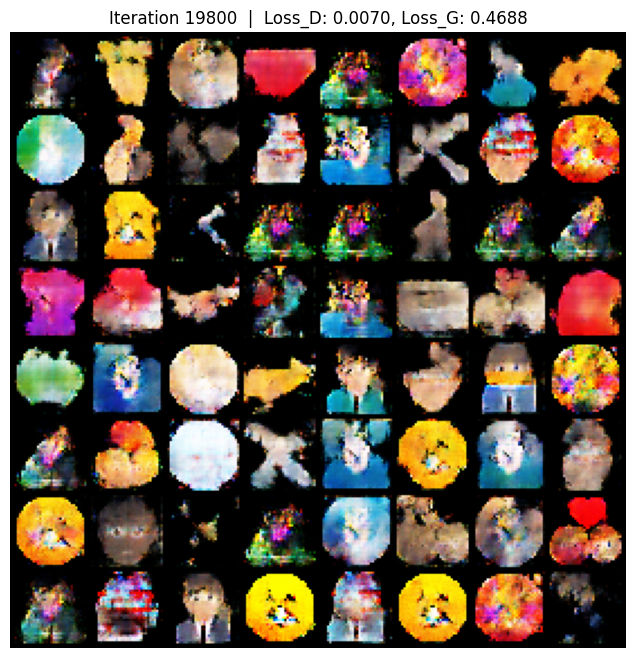

[19900/20000] LossD: 0.0083 LossG: 0.4782


In [16]:
# =============================
# 4. Training Loop (20000 iterations)
# =============================
iterations = 20000
save_interval = 200
iter_count = 0

dataloader_iter = iter(dataloader)

while iter_count < iterations:
    try:
        real = next(dataloader_iter)
    except StopIteration:
        dataloader_iter = iter(dataloader)
        real = next(dataloader_iter)

    real = real.to(device)
    b_size = real.size(0)

    # Labels
    label_real = torch.ones(b_size, device=device)
    label_fake = torch.zeros(b_size, device=device)

    # ----------------------
    # Train Discriminator
    # ----------------------
    netD.zero_grad()
    output_real = netD(real)
    lossD_real = 0.5 * criterion(output_real, label_real)

    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    output_fake = netD(fake.detach())
    lossD_fake = 0.5 * criterion(output_fake, label_fake)

    lossD = lossD_real + lossD_fake
    lossD.backward()
    optimizerD.step()

    # ----------------------
    # Train Generator
    # ----------------------
    netG.zero_grad()
    output = netD(fake)
    lossG = 0.5 * criterion(output, label_real)
    lossG.backward()
    optimizerG.step()



    # Print and save progress
    if iter_count % 100 == 0:
        print(f"[{iter_count}/{iterations}] LossD: {lossD.item():.4f} LossG: {lossG.item():.4f}")

    if iter_count % save_interval == 0:
        with torch.no_grad():
            fake_images = netG(fixed_noise).detach().cpu()


        # Show in Colab output
        grid = make_grid(fake_images, padding=2, normalize=True)
        display.clear_output(wait=True)  # clear previous grid
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title(f"Iteration {iter_count}  |  Loss_D: {lossD.item():.4f}, Loss_G: {lossG.item():.4f}")
        plt.imshow(np.transpose(grid, (1,2,0)))
        plt.show()

        save_image(make_grid(fake_images, normalize=True), f"progress/fake_{iter_count}.png")

    iter_count += 1

# Save final model
torch.save(netG.state_dict(), "checkpoints/netG.pth")
torch.save(netD.state_dict(), "checkpoints/netD.pth")


In [17]:
# =============================
# 5. Generate 3000 Images for FID
# =============================
netG.eval()
n_samples = 3000
batch_size = 100
os.makedirs("generated", exist_ok=True)

for i in range(0, n_samples, batch_size):
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    with torch.no_grad():
        fake = netG(noise).detach().cpu()
    for j in range(batch_size):
        save_image(fake[j], f"generated/fake_{i+j}.png", normalize=True)

print("✅ 3000 images saved in generated/")


✅ 3000 images saved in generated/


In [18]:
# =============================
# 6. Compute FID
# =============================
from cleanfid import fid

# Compute FID between real (training set) and generated samples
fid_score = fid.compute_fid(
    data_path,  # real images
    "generated",  # fake images
    mode="clean",
    num_workers=2
)

print("FID Score:", fid_score)


compute FID between two folders
Found 3671 images in the folder joypixels/png/unicode/32


FID 32 : 100%|██████████| 115/115 [00:22<00:00,  5.14it/s]


Found 3000 images in the folder generated


FID generated : 100%|██████████| 94/94 [00:18<00:00,  5.12it/s]


FID Score: 161.94303018387373
